In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/DeepMecProject/datasetFER2013/archive5.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [2]:
from sklearn.model_selection import train_test_split
import json
import os
from tqdm.auto import tqdm
import shutil
import random
import cv2

# Instalar la librería de Kaggle para descargar datasets
!pip install kaggle

# Antes de descargar el dataset, es importante definir las credenciales para acceder al API de Kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Puedes crear tu propio token y username de la API de Kaggle en https://www.kaggle.com/
api_token = {"username":"benjaminvillegas","key":"51aee955395f28ce555fbc0a8abb4481"}

# Crear un archivo con las credenciales, de tal forma que kaggle pueda leerlas facilmente
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
%cd /content

# Comprobar si el conjunto de datos ya se ha descargado
if not os.path.exists('./affectnethq'):
  os.makedirs('affectnethq')
else: 
  !rm -rf affectnethq

# Descargar un dataset desde Kaggle
#!kaggle datasets download -d tunhunhminh/demodata -p city_problems
!kaggle datasets download -d tom99763/affectnethq



/content
100% 8.09G/8.12G [01:12<00:00, 147MB/s]
100% 8.12G/8.12G [01:13<00:00, 119MB/s]


In [4]:
# Descomprimir dataset 
!unzip -qn '/content/affectnethq.zip' -d /content/affectnethq > /dev/null
!rm /content/affectnethq.zip

In [3]:
categories = ["surprise","happy","anger","disgust","fear","sad","neutral"]
#dataset = pd.read_csv('/content/affectnethq/labels.csv')

In [6]:
dataset["label"][0]

'surprise'

In [7]:
cad=dataset["pth"][0]
s=cad.split('/')
cad2=s[1]
cad2

'image0000006.jpg'

In [8]:
#movemos cada imagen a su carpeta respectiva segun el archivo csv
for idx, sample in enumerate(dataset["label"]):
  s=dataset["pth"][idx]
  cad=s.split('/')
  direc=cad[1]
  shutil.move("/content/affectnethq/"+dataset["pth"][idx],"/content/affectnethq/"+dataset["label"][idx]+"/"+direc)


In [9]:
#comprobamos que el nuero de imagenes corresponda a cierta categoria segun e
import os
initial_count = 0
dir = "/content/affectnethq/sad"
for path in os.listdir(dir):
    if os.path.isfile(os.path.join(dir, path)):
        initial_count += 1
print(initial_count)

3344


In [10]:
count=0
for i, sample in enumerate(dataset["label"]):
  if sample=='sad':
    count=count+1
print(count)

3352


In [4]:
#dividimos el dataset
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from sklearn.model_selection import train_test_split
import json
import os
from tqdm.auto import tqdm
import shutil
import random
import cv2

In [9]:
import splitfolders  

#Dividir una carpeta en 80% train y 20% test
splitfolders.ratio("/content/affectnethq", output="/content/dataAffect2", seed=1337, ratio=(.7, .15, .15), group_prefix=None) # default values

ValueError: ignored

In [10]:
import splitfolders  

#Dividir una carpeta en 80% train y 20% test
splitfolders.ratio("/content/archive5/emotion_faces", output="/content/ck+fer2013", seed=1337, ratio=(.7, .15, .15), group_prefix=None) # default values

Copying files: 18980 files [00:03, 5919.21 files/s]


In [11]:
# Buscar dentro los directorios
data_dir = '/content/ck+fer2013'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/val")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')
print(f'Test Classes - {classes_test}')

['val', 'test', 'train']
Train Classes - ['sad', 'angry', 'surprise', 'neutral', 'disgust', 'happy', 'fear']
Validation Classes - ['sad', 'angry', 'surprise', 'neutral', 'disgust', 'happy', 'fear']
Test Classes - ['sad', 'angry', 'surprise', 'neutral', 'disgust', 'happy', 'fear']


In [12]:
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [175]:
# Todas las imágenes seran divididas entre el maximo valor por canal, por lo que quedaran rescaladas entre el 0 y 1. 
train_datagen = ImageDataGenerator(rescale=1/255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Tamaño del lote (imágenes a procesar por el modelo al mismo tiempo)
BATCH_SIZE = 62
TRAINSET_PATH="/content/ck+fer2013/train"
VALIDSET_PATH = "/content/ck+fer2013/val"
TESTSET_PATH = "/content/ck+fer2013/test"


# Importar datos desde los directorios y convertirlos en lotes de tensores
train_data = train_datagen.flow_from_directory(TRAINSET_PATH,
                                               batch_size=BATCH_SIZE, # tamaño del lote
                                               color_mode='grayscale',
                                               target_size=(48, 48), # convertir todas las imágenes a 224 x 224
                                               class_mode="categorical", # tipo de problema, usar 'binary' si tuviesemos dos clases
                                               seed=42) # semilla para generar las mismas selecciones durante los experimentos

valid_data = valid_datagen.flow_from_directory(VALIDSET_PATH,
                                               batch_size=BATCH_SIZE,
                                               color_mode='grayscale',
                                               target_size=(48, 48),
                                               class_mode="categorical",
                                               seed=42)
test_data = test_datagen.flow_from_directory(TESTSET_PATH,
                                               batch_size=BATCH_SIZE,
                                               color_mode='grayscale',
                                               target_size=(48, 48),
                                               class_mode="categorical",
                                               seed=42)


Found 13283 images belonging to 7 classes.
Found 2844 images belonging to 7 classes.
Found 2853 images belonging to 7 classes.


In [177]:
#cargamos el modelo efficientNet de keras
from tensorflow.keras.applications import ResNet50
img_input = tf.keras.layers.Input(shape=(48, 48,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])  

base_model = ResNet50(include_top = False, weights = None,input_tensor=img_conc, classes=7)#classes=7



In [162]:
cfg = base_model.get_config()
cfg['layers'][0]['config']['batch_input_shape'] = (None, 48, 48, 1)
resnet_model = Model.from_config(cfg) 


for i, layer in enumerate(resnet_model.layers):
    if i == 1:
#         print('up')
        new_weights = base_model.layers[i].get_weights()[0].sum(axis=2, keepdims=True)
        resnet_model.set_weights([new_weights])
        layer.trainable = False
    else: 
        break

In [154]:
#congelamos layers
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 concatenate_20 (Concatenate)   (None, 48, 48, 3)    0           ['input_21[0][0]',               
                                                                  'input_21[0][0]',               
                                                                  'input_21[0][0]']               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['concatenate_20[0][0]']         
                                                                                           

In [178]:
last_layers=base_model.get_layer('conv2_block1_out')
last_output=last_layers.output

In [179]:
#x = tf.keras.layers.Dense(128, activation="relu")(last_output)
x = tf.keras.layers.Flatten()(last_output)

x = tf.keras.layers.Dropout(0.5)(x)#(last_output)
#x = tf.keras.layers.Dense(128, activation="relu")(x)
#x = tf.keras.layers.Flatten()(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = tf.keras.layers.Dense(7, activation="softmax")(x)
model_final = Model(base_model.input, predictions)

In [180]:
model_final.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.002),loss='categorical_crossentropy',metrics=['accuracy'])               

In [181]:
model_final.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 concatenate_24 (Concatenate)   (None, 48, 48, 3)    0           ['input_25[0][0]',               
                                                                  'input_25[0][0]',               
                                                                  'input_25[0][0]']               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['concatenate_24[0][0]']         
                                                                                           

In [182]:
mn_history = model_final.fit(train_data,validation_data = valid_data, epochs = 150)#,steps_per_epoch = 100)

Epoch 1/150
215/215 [==============================] - 17s 58ms/step - loss: 4.1307 - accuracy: 0.2038 - val_loss: 14.4874 - val_accuracy: 0.1709
Epoch 2/150
215/215 [==============================] - 11s 51ms/step - loss: 1.8517 - accuracy: 0.2536 - val_loss: 5.9556 - val_accuracy: 0.1776
Epoch 3/150
215/215 [==============================] - 12s 56ms/step - loss: 1.8223 - accuracy: 0.2700 - val_loss: 5.1449 - val_accuracy: 0.2124
Epoch 4/150
215/215 [==============================] - 11s 53ms/step - loss: 1.7984 - accuracy: 0.2809 - val_loss: 5.6795 - val_accuracy: 0.1955
Epoch 5/150
215/215 [==============================] - 11s 51ms/step - loss: 1.7885 - accuracy: 0.2872 - val_loss: 3.0643 - val_accuracy: 0.2416
Epoch 6/150
215/215 [==============================] - 11s 51ms/step - loss: 1.7734 - accuracy: 0.2917 - val_loss: 2.4052 - val_accuracy: 0.2873
Epoch 7/150
215/215 [==============================] - 11s 52ms/step - loss: 1.7627 - accuracy: 0.3014 - val_loss: 4.1348 - val_a

In [187]:
# Guardar el Modelo
model_final.save('/content/drive/MyDrive/DeepMecProject/model2.h5')
model_final.save('/content/drive/MyDrive/DeepMecProject/model3', save_format='tf')
# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = keras.models.load_model('/content/drive/MyDrive/DeepMecProject/model2.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepMecProject/model3/assets


2/2 [==============================] - 0s 47ms/step - loss: 2.3657 - accuracy: 0.3871
              precision    recall  f1-score   support

           0       0.30      0.43      0.35         7
           1       1.00      0.40      0.57         5
           2       0.14      0.17      0.15         6
           3       0.54      0.54      0.54        13
           4       0.50      0.08      0.14        12
           5       0.50      0.12      0.20         8
           6       0.35      0.82      0.49        11

    accuracy                           0.39        62
   macro avg       0.48      0.37      0.35        62
weighted avg       0.46      0.39      0.35        62



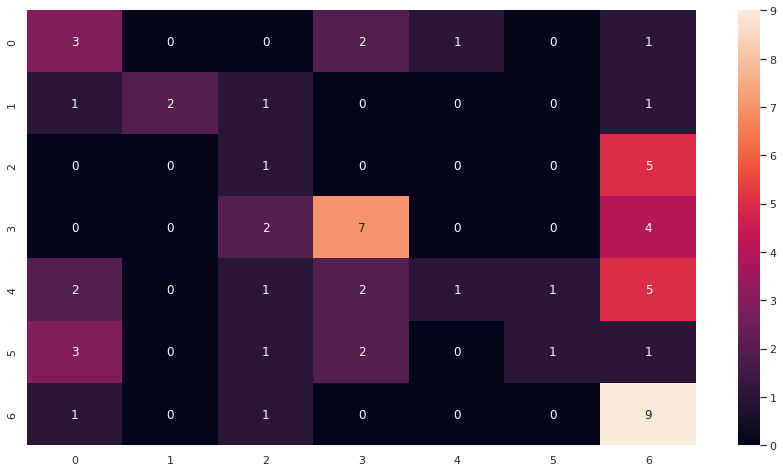

In [184]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import sklearn.metrics as metrics 

test_batch =[]
for data in next(test_data):
  test_batch.append(data)

image_batch = test_batch[0]
label_batch= test_batch[1]

loss, accuracy = model_final.evaluate(image_batch, label_batch)
predictions= tf.argmax(model_final.predict(image_batch),axis=1)
label_batch = tf.argmax(label_batch, axis=1)
cf_matrix = tf.math.confusion_matrix(label_batch, predictions)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cf_matrix, annot=True)
f1_score = metrics.classification_report(label_batch, predictions)
print(f1_score)


In [186]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/DeepMecProject/model2.h5')

In [190]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/DeepMecProject/model3')

In [197]:
#cargamos el modelo efficientNet de keras
from tensorflow.keras.applications import MobileNetV3Small
img_input = tf.keras.layers.Input(shape=(48, 48,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])  

base_model2 = MobileNetV3Small(include_top = False, weights = None,input_tensor=img_conc, classes=7)#classes=7

In [202]:
base_model2.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 concatenate_27 (Concatenate)   (None, 48, 48, 3)    0           ['input_28[0][0]',               
                                                                  'input_28[0][0]',               
                                                                  'input_28[0][0]']               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 48, 48, 3)    0           ['concatenate_27[0][0]']         
                                                                                   

In [203]:
last_layers=base_model2.get_layer('re_lu_94')
last_output=last_layers.output

In [205]:
#x = tf.keras.layers.Dense(576, activation="relu")(ba)
x = tf.keras.layers.Flatten()(last_output)

x = tf.keras.layers.Dropout(0.5)(x)#(last_output)
#x = tf.keras.layers.Dense(128, activation="relu")(x)
#x = tf.keras.layers.Flatten()(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = tf.keras.layers.Dense(7, activation="softmax")(x)
model_final = Model(base_model2.input, predictions)

In [206]:
model_final.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.002),loss='categorical_crossentropy',metrics=['accuracy'])               

In [207]:
mn2_history = model_final.fit(train_data,validation_data = valid_data, epochs = 50)

Epoch 1/50
215/215 [==============================] - 15s 71ms/step - loss: 1.9095 - accuracy: 0.2025 - val_loss: 1.9421 - val_accuracy: 0.1733
Epoch 3/50
215/215 [==============================] - 15s 69ms/step - loss: 1.9029 - accuracy: 0.2012 - val_loss: 1.9009 - val_accuracy: 0.1748
Epoch 4/50
215/215 [==============================] - 16s 74ms/step - loss: 1.8979 - accuracy: 0.1927 - val_loss: 1.9009 - val_accuracy: 0.1723
Epoch 5/50
215/215 [==============================] - 15s 70ms/step - loss: 1.8911 - accuracy: 0.2022 - val_loss: 1.8999 - val_accuracy: 0.1723
Epoch 6/50
215/215 [==============================] - 15s 70ms/step - loss: 1.8845 - accuracy: 0.2000 - val_loss: 1.9012 - val_accuracy: 0.1733
Epoch 7/50
215/215 [==============================] - 14s 67ms/step - loss: 1.8823 - accuracy: 0.2096 - val_loss: 1.9122 - val_accuracy: 0.1614
Epoch 8/50
215/215 [==============================] - 14s 66ms/step - loss: 1.8743 - accuracy: 0.2168 - val_loss: 1.9204 - val_accuracy: